In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline

Gaussian Mixture

$\{x_n\}$ are observed, each with a corresponding $z_n$ that takes value 0 or 1. If $z_{nk} = 1$ means $x_n$ belongs to cluster $k$. 

With one datapoint $x$ and the corresponding $z$, let's just write down some useful quantities:
$$
\begin{align*}
p(z_k = 1) &= \pi_k\\
p(x\mid z_k = 1) &= \mathcal{N}(x; \mu_k, \Sigma_k)\\
p(x) &= \sum_k p(x\mid z_k = 1) p(z_k = 1)\\
&=\sum_k \pi_k\mathcal{N}(x;\mu_k, \Sigma_k)\\
p(z_k = 1\mid x) &= \frac{p(x\mid z_k = 1)p(z_k = 1)}{p(x)}\\
&=\frac{\pi_k\mathcal{N}(x;\mu_k, \Sigma_k)}{\sum_j \pi_j\mathcal{N}(x;\mu_j, \Sigma_j)}\\
&=\gamma(z_k)
\end{align*}
$$

The log-likelihood, where $\theta = \{\mu, \Sigma, \pi\}$:
$$
\begin{align*}
\mathcal{LL} &= \log p(X\mid \theta) = \log \prod_N p(x_n\mid \theta)\\
&=\sum_N \log \sum_K \pi_k\mathcal{N}(x_n;\mu_k, \Sigma_k)
\end{align*}
$$

Partial derivative against $\mu_k$:
$$
\begin{align*}
\frac{\partial \mathcal{LL}}{\partial \mu_k} &=\sum_N \frac{1}{\sum_K \pi_k\mathcal{N}(x_n;\mu_k, \Sigma_k)} \frac{\partial \ \pi_k\mathcal{N}(x_n;\mu_k, \Sigma_k)}{\partial \mu_k} \\
&=\sum_N \frac{\pi_k\mathcal{N}(x_n;\mu_k, \Sigma_k)}{\sum_K \pi_k\mathcal{N}(x_n;\mu_k, \Sigma_k)} \Sigma^{-1}(x_n - \mu_k) \\
&=\Sigma^{-1}\sum_N \gamma(z_{nk}) (x_n - \mu_k) 
\end{align*}
$$
Set to 0:
$$
\begin{align*}
\Sigma^{-1}\sum_N \gamma(z_{nk}) (x_n - \mu_k) &= 0\\
\sum_N \gamma(z_{nk}) x_n  &= \mu_k\sum_N \gamma(z_{nk})\\
\mu_k &= \frac{1}{\sum_N \gamma(z_{nk})}\sum_N \gamma(z_{nk}) x_n\\
\mu_k^\text{new} &= \frac{1}{N_k}\sum_N \gamma(z_{nk}) x_n
\end{align*}
$$

Doing similar calculations for $\Sigma$ and $\pi$, (though $\pi$ needs to sum to 1 with lagrange multiplier):
$$
\begin{align*}
\Sigma_k^\text{new} &= \frac{1}{N_k}\sum_N \gamma(z_{nk})(x_n - \mu_k^\text{new})(x_n - \mu_k^\text{new})^T\\
\pi_k^\text{new} &= \frac{N_k}{N}
\end{align*}
$$

In the previous block, the $\gamma(z_{nk})$ quantity is of special interest. It can be seen as a $N\times K$ matrix of $z$-values, and the $\gamma$ function is picking them out. Each row of the matrix sum to 1 (i.e. $\sum_k \gamma(z_{nk}) = 1$) and each column sum to $N_k = \sum_n \gamma(z_{nk})$. Row $n$ shows how likely $x_n$ belongs to each cluster and $N_k$ is the "number" of points assigned to cluter $k$.

1. E: evaluate $\gamma$ fixing $\theta$
2. M: new $\theta$ using update rules
3. Evaluate likelihood

In [67]:
np.random.seed(42)
# Generate data following the generative process
_m0, _cov0 = [-3, -3], [[0.5, 0], [0, 3]]
_m1, _cov1 = [0, 0], [[3, 0], [0, 0.5]]
_m2, _cov2 = [3, 3], [[0.5, 0], [0, 3]]
_pi = [0.25, 0.5, 0.25]

X = []
c = []
N = 100
for _ in range(N):
    k = np.random.choice([0, 1, 2], p=_pi)
    c.append(k)
    X.append(np.random.multivariate_normal(globals()[f'_m{k}'], globals()[f'_cov{k}'], 1)[0])
X = np.array(X)

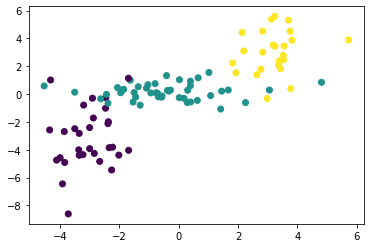

In [68]:
plt.scatter(X[:,0], X[:,1], c=c)

In [109]:
# Init to 3 unit gaussian equally spaced
m0, cov0 = [-1, 0], [[1, 0], [0, 1]]
m1, cov1 = [0, 0], [[1, 0], [0, 1]]
m2, cov2 = [1, 0], [[1, 0], [0, 1]]
pi = [0.333, 0.333, 0.333]
K = 3

In [110]:
from scipy.stats import multivariate_normal
p0 = p1 = p2 = None
def update_normal():
    global p0, p1, p2
    p0 = multivariate_normal(mean=m0, cov=cov0)
    p1 = multivariate_normal(mean=m1, cov=cov1)
    p2 = multivariate_normal(mean=m2, cov=cov2)

Evaluate likelihood:

$$
\begin{align*}
\mathcal{LL} =\sum_N \log  \sum_K \pi_k\mathcal{N}(x_n;\mu_k, \Sigma_k)
\end{align*}
$$

In [111]:
def evaluate():
    LL = []
    for n in range(N):
        acc = 0
        for k in range(K):
            v = pi[k] * globals()[f'p{k}'].pdf(X[n])
            acc += v
        LL.append(acc)
    return np.sum(np.log(LL))

Expectation:
$$
\begin{align*}
\gamma(z_k)=\frac{\pi_k\mathcal{N}(x;\mu_k, \Sigma_k)}{\sum_j \pi_j\mathcal{N}(x;\mu_j, \Sigma_j)}
\end{align*}
$$

In [112]:
def expectation():
    gamma = np.zeros((len(X), K))

    for n in range(N):
        denom = 0
        for k in range(K):
            nom = pi[k] * globals()[f'p{k}'].pdf(X[n])
            gamma[n][k] = nom
            denom += nom
        gamma[n] /= denom
    return gamma

Maximization:
$$
\begin{align*}
\mu_k^\text{new} &= \frac{1}{N_k}\sum_N \gamma(z_{nk}) x_n\\
\Sigma_k^\text{new} &= \frac{1}{N_k}\sum_N \gamma(z_{nk})(x_n - \mu_k^\text{new})(x_n - \mu_k^\text{new})^T\\
\pi_k^\text{new} &= \frac{N_k}{N}
\end{align*}
$$

In [113]:
def maximization(gamma):
    for k in range(K):
        N_k = np.sum(gamma[:, k])
        # new mean first
        mu_new = np.zeros(2)
        for n in range(N):
            mu_new += gamma[n][k] * X[n]
        mu_new /= N_k
        # then new covariance
        cov_new = np.zeros((2, 2))
        for n in range(N):
            diff = X[n] - mu_new
            cov_new += gamma[n][k] * np.outer(diff, diff)
        cov_new /= N_k
        globals()[f'm{k}'] = mu_new
        globals()[f'cov{k}'] = cov_new
        pi[k] = N_k / N

Iterate

In [114]:
loglik = []
for i in range(20):
    update_normal()
    loglik.append(evaluate())
    maximization(expectation())

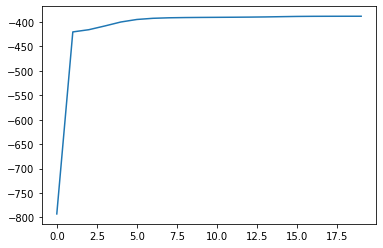

In [115]:
plt.plot(loglik)

In [118]:
m0, m1, m2

(array([-3.05275206, -3.65314494]),
 array([-0.79671277,  0.15501593]),
 array([3.17428623, 2.82646976]))

In [119]:
cov0, cov1, cov2

(array([[0.5192079 , 0.32665688],
        [0.32665688, 3.10352584]]),
 array([[ 2.37700707, -0.05816294],
        [-0.05816294,  0.34631836]]),
 array([[0.79257978, 0.24995004],
        [0.24995004, 2.52585223]]))

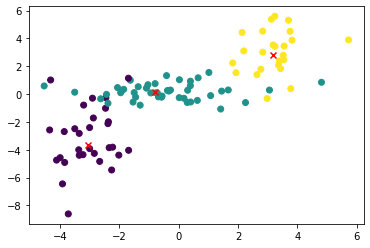

In [120]:
plt.scatter(X[:,0], X[:,1], c=c)
plt.scatter(m0[0], m0[1], c='red', marker='x')
plt.scatter(m1[0], m1[1], c='red', marker='x')
plt.scatter(m2[0], m2[1], c='red', marker='x')